# Chest X-Ray Dataset Exploratory Data Analysis (EDA)

**Objective**: Comprehensive analysis of ChestX-ray14 dataset to understand class distribution, imbalance, and inform preprocessing/training strategy.

**Dataset**: NIH ChestX-ray14 (112,120 frontal-view X-rays, 14 disease classes, multi-label)

**Date**: January 21, 2026

---

## 1. Setup & Imports

In [6]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Set project root
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

# Import project config
from config import Config, DISEASE_LABELS, NUM_CLASSES

print(f"Project Root: {project_root}")
print(f"Number of Disease Classes: {NUM_CLASSES}")
print(f"Disease Classes: {DISEASE_LABELS}")

Project Root: c:\Users\User\Sadeepa\X-Lite
Number of Disease Classes: 14
Disease Classes: ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']


## 2. Load Dataset Metadata

In [7]:
# Load metadata CSV
metadata_path = Config.METADATA_CSV
print(f"Loading metadata from: {metadata_path}")

df = pd.read_csv(metadata_path)

print(f"\n✓ Dataset loaded successfully!")
print(f"  Total records: {len(df):,}")
print(f"  Columns: {list(df.columns)}")
print(f"\nFirst 5 rows:")
df.head()

Loading metadata from: c:\Users\User\Sadeepa\X-Lite\data\Data_Entry_2017.csv

✓ Dataset loaded successfully!
  Total records: 112,120
  Columns: ['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11']

First 5 rows:


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


## 3. Dataset Basic Statistics

In [8]:
print("="*70)
print("DATASET STATISTICS")
print("="*70)

# Column names in metadata
print(f"\nDataframe Info:")
print(df.info())

print(f"\nBasic Statistics:")
print(f"  Total Images: {len(df):,}")
print(f"  Unique Image IDs: {df.iloc[:, 0].nunique():,}")
print(f"  Patients: {df.iloc[:, 4].nunique():,}" if df.shape[1] > 4 else "  N/A")

print(f"\nDataset Overview:")
print(df.describe())

DATASET STATISTICS

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5

## 4. Disease Label Analysis

In [9]:
# Parse disease labels (column 1 contains pipe-separated labels)
# NOTE: We use 14 sigmoid outputs (one per disease)
# "No Finding" is handled at inference: if all 14 outputs < threshold → No Finding

label_column = df.iloc[:, 1]  # Typically column 1 (index 1) has labels

# Count each disease occurrence
disease_counts = {}
total_labels = 0
images_with_no_disease = 0

for labels in label_column:
    if pd.isna(labels):
        images_with_no_disease += 1
        continue
    
    label_str = str(labels).strip()
    
    if label_str == 'No Finding':
        images_with_no_disease += 1
    else:
        # Split by pipe and count
        diseases = [d.strip() for d in label_str.split('|')]
        for disease in diseases:
            disease_counts[disease] = disease_counts.get(disease, 0) + 1
            total_labels += 1

print("="*70)
print("DISEASE LABEL DISTRIBUTION (14 Sigmoid Outputs)")
print("="*70)

# Sort by count
sorted_diseases = sorted(disease_counts.items(), key=lambda x: x[1], reverse=True)

print(f"\nTotal Disease Occurrences: {total_labels:,}")
print(f"Images with 'No Finding': {images_with_no_disease:,} ({images_with_no_disease/len(df)*100:.1f}%)")
print(f"Images with ≥1 disease: {len(df) - images_with_no_disease:,} ({(len(df)-images_with_no_disease)/len(df)*100:.1f}%)")

print(f"\n{'Rank':<6} {'Disease (Output Head)':<30} {'Count':<12} {'Percentage':<12}")
print("-"*70)

for rank, (disease, count) in enumerate(sorted_diseases, 1):
    percentage = (count / len(df)) * 100
    print(f"{rank:<6} {disease:<30} {count:<12,} {percentage:<12.2f}%")

print("-"*70)
print(f"\n✓ Total Output Heads: {len(sorted_diseases)} (14 sigmoid outputs)")
print(f"✓ No Finding: Derived at inference (all outputs < threshold)")


DISEASE LABEL DISTRIBUTION (14 Sigmoid Outputs)

Total Disease Occurrences: 81,176
Images with 'No Finding': 60,361 (53.8%)
Images with ≥1 disease: 51,759 (46.2%)

Rank   Disease (Output Head)          Count        Percentage  
----------------------------------------------------------------------
1      Infiltration                   19,894       17.74       %
2      Effusion                       13,317       11.88       %
3      Atelectasis                    11,559       10.31       %
4      Nodule                         6,331        5.65        %
5      Mass                           5,782        5.16        %
6      Pneumothorax                   5,302        4.73        %
7      Consolidation                  4,667        4.16        %
8      Pleural_Thickening             3,385        3.02        %
9      Cardiomegaly                   2,776        2.48        %
10     Emphysema                      2,516        2.24        %
11     Edema                          2,303        

## 5. Class Imbalance Metrics

In [10]:
# Calculate imbalance metrics
print("\n" + "="*70)
print("CLASS IMBALANCE ANALYSIS (14 Disease Outputs)")
print("="*70)

# Get counts
counts = np.array([count for _, count in sorted_diseases])

# Metrics
min_count = counts.min()
max_count = counts.max()
imbalance_ratio = max_count / min_count

print(f"\nImbalance Metrics (among 14 diseases):")
print(f"  Max count: {max_count:,}")
print(f"  Min count: {min_count:,}")
print(f"  Imbalance ratio (max/min): {imbalance_ratio:.2f}:1")

# Gini coefficient (measure of inequality)
def gini_coefficient(counts):
    n = len(counts)
    sorted_counts = np.sort(counts)
    cumsum = np.cumsum(sorted_counts)
    gini = (2 * np.sum(np.arange(1, n+1) * sorted_counts)) / (n * np.sum(sorted_counts)) - (n + 1) / n
    return gini

gini = gini_coefficient(counts)
print(f"  Gini coefficient: {gini:.4f} (0=perfect balance, 1=extreme imbalance)")

# Effective number of samples (recommended for imbalanced data)
def effective_num_samples(counts, beta=0.9999):
    return (1 - beta) / (1 - (beta ** counts))

effective_counts = effective_num_samples(counts)
print(f"\n  Effective number of samples (β=0.9999):")
for (disease, _), eff in zip(sorted_diseases, effective_counts):
    print(f"    {disease}: {eff:.0f}")

# Class weights (inverse frequency)
class_weights = {disease: len(df) / (count * len(sorted_diseases)) 
                 for disease, count in sorted_diseases}

print(f"\n  Recommended class weights (inverse frequency):")
for disease, weight in sorted(class_weights.items(), key=lambda x: x[1], reverse=True):
    print(f"    {disease}: {weight:.4f}")

print(f"\n💡 NOTE: 'No Finding' is NOT a separate output head.")
print(f"    At inference: if all 14 outputs < threshold → classified as 'No Finding'")



CLASS IMBALANCE ANALYSIS (14 Disease Outputs)

Imbalance Metrics (among 14 diseases):
  Max count: 19,894
  Min count: 227
  Imbalance ratio (max/min): 87.64:1
  Gini coefficient: 0.4652 (0=perfect balance, 1=extreme imbalance)

  Effective number of samples (β=0.9999):
    Infiltration: 0
    Effusion: 0
    Atelectasis: 0
    Nodule: 0
    Mass: 0
    Pneumothorax: 0
    Consolidation: 0
    Pleural_Thickening: 0
    Cardiomegaly: 0
    Emphysema: 0
    Edema: 0
    Fibrosis: 0
    Pneumonia: 0
    Hernia: 0

  Recommended class weights (inverse frequency):
    Hernia: 35.2801
    Pneumonia: 5.5965
    Fibrosis: 4.7500
    Edema: 3.4775
    Emphysema: 3.1831
    Cardiomegaly: 2.8849
    Pleural_Thickening: 2.3659
    Consolidation: 1.7160
    Pneumothorax: 1.5105
    Mass: 1.3851
    Nodule: 1.2650
    Atelectasis: 0.6928
    Effusion: 0.6014
    Infiltration: 0.4026

💡 NOTE: 'No Finding' is NOT a separate output head.
    At inference: if all 14 outputs < threshold → classified as 

## 6. Multi-Label Statistics

In [11]:
# Count diseases per image (excluding "No Finding")
diseases_per_image = []

for labels in label_column:
    if pd.isna(labels):
        diseases_per_image.append(0)
    else:
        label_str = str(labels).strip()
        if label_str == 'No Finding':
            diseases_per_image.append(0)
        else:
            disease_count = len([d.strip() for d in label_str.split('|') if d.strip()])
            diseases_per_image.append(disease_count)

df['num_diseases'] = diseases_per_image

print("\n" + "="*70)
print("MULTI-LABEL STATISTICS (14 Disease Outputs)")
print("="*70)

print(f"\nNumber of diseases per image (positive labels only):")
dist = df['num_diseases'].value_counts().sort_index()
for num_diseases, count in dist.items():
    percentage = (count / len(df)) * 100
    print(f"  {num_diseases} disease(s): {count:>6,} images ({percentage:>5.1f}%)")

print(f"\nSummary:")
print(f"  Mean diseases per image: {df['num_diseases'].mean():.2f}")
print(f"  Median diseases per image: {df['num_diseases'].median():.0f}")
print(f"  Max diseases per image: {df['num_diseases'].max():.0f}")
print(f"  Min diseases per image: {df['num_diseases'].min():.0f}")
print(f"  Std dev: {df['num_diseases'].std():.2f}")

print(f"\nClass distribution:")
no_disease = len(df[df['num_diseases'] == 0])
single_disease = len(df[df['num_diseases'] == 1])
multi_disease = len(df[df['num_diseases'] > 1])
print(f"  No Finding (0 diseases): {no_disease:,} ({no_disease/len(df)*100:.1f}%)")
print(f"  Single disease: {single_disease:,} ({single_disease/len(df)*100:.1f}%)")
print(f"  Multi-disease (>1): {multi_disease:,} ({multi_disease/len(df)*100:.1f}%)")

print(f"\n💡 NOTE: During training, each disease is a binary label (0 or 1)")
print(f"    At inference, a sample is 'No Finding' iff all 14 outputs < threshold")



MULTI-LABEL STATISTICS (14 Disease Outputs)

Number of diseases per image (positive labels only):
  0 disease(s): 60,361 images ( 53.8%)
  1 disease(s): 30,963 images ( 27.6%)
  2 disease(s): 14,306 images ( 12.8%)
  3 disease(s):  4,856 images (  4.3%)
  4 disease(s):  1,247 images (  1.1%)
  5 disease(s):    301 images (  0.3%)
  6 disease(s):     67 images (  0.1%)
  7 disease(s):     16 images (  0.0%)
  8 disease(s):      1 images (  0.0%)
  9 disease(s):      2 images (  0.0%)

Summary:
  Mean diseases per image: 0.72
  Median diseases per image: 0
  Max diseases per image: 9
  Min diseases per image: 0
  Std dev: 0.96

Class distribution:
  No Finding (0 diseases): 60,361 (53.8%)
  Single disease: 30,963 (27.6%)
  Multi-disease (>1): 20,796 (18.5%)

💡 NOTE: During training, each disease is a binary label (0 or 1)
    At inference, a sample is 'No Finding' iff all 14 outputs < threshold


## 7. Disease Co-Occurrence Analysis

In [12]:
# Build co-occurrence matrix
from itertools import combinations

co_occurrence = {}

for labels in label_column:
    if pd.isna(labels):
        continue
    
    label_str = str(labels).strip()
    if label_str == 'No Finding':
        continue
    
    diseases = [d.strip() for d in label_str.split('|')]
    
    # Count pairs
    for disease_pair in combinations(sorted(diseases), 2):
        key = tuple(sorted(disease_pair))
        co_occurrence[key] = co_occurrence.get(key, 0) + 1

print("\n" + "="*70)
print("DISEASE CO-OCCURRENCE (Top 15 pairs)")
print("="*70)

sorted_pairs = sorted(co_occurrence.items(), key=lambda x: x[1], reverse=True)[:15]

print(f"\n{'Rank':<6} {'Disease 1':<20} {'Disease 2':<20} {'Co-occurrence':<12}")
print("-"*70)

for rank, ((disease1, disease2), count) in enumerate(sorted_pairs, 1):
    print(f"{rank:<6} {disease1:<20} {disease2:<20} {count:<12,}")

print("-"*70)
print(f"\nTotal unique disease pairs: {len(co_occurrence)}")


DISEASE CO-OCCURRENCE (Top 15 pairs)

Rank   Disease 1            Disease 2            Co-occurrence
----------------------------------------------------------------------
1      Effusion             Infiltration         4,000       
2      Atelectasis          Effusion             3,275       
3      Atelectasis          Infiltration         3,264       
4      Infiltration         Nodule               1,546       
5      Consolidation        Effusion             1,287       
6      Effusion             Mass                 1,254       
7      Atelectasis          Consolidation        1,223       
8      Consolidation        Infiltration         1,221       
9      Infiltration         Mass                 1,159       
10     Cardiomegaly         Effusion             1,063       
11     Effusion             Pneumothorax         996         
12     Edema                Infiltration         981         
13     Infiltration         Pneumothorax         946         
14     Effusion      

## 8. Image File Validation

In [13]:
print("\n" + "="*70)
print("IMAGE FILE VALIDATION")
print("="*70)

image_dir = Config.RAW_DATA_DIR / 'images'

if not image_dir.exists():
    print(f"\n⚠️  Image directory not found: {image_dir}")
    print(f"Expected path: {Config.RAW_DATA_DIR}")
    print(f"\nPlease ensure images are extracted to: {image_dir}")
else:
    # Count actual image files
    image_files = list(image_dir.glob("*.png"))
    image_count = len(image_files)
    
    print(f"\n✓ Image directory found: {image_dir}")
    print(f"  Total image files: {image_count:,}")
    print(f"  Expected from metadata: {len(df):,}")
    
    if image_count == len(df):
        print(f"  ✓ Counts match!")
    else:
        print(f"  ⚠️  Count mismatch! ({len(df) - image_count:,} missing)")
    
    # Sample image info
    if image_files:
        print(f"\n  Sample image info:")
        for img_path in image_files[:3]:
            try:
                img = Image.open(img_path)
                print(f"    {img_path.name}: {img.size} pixels, mode={img.mode}")
            except Exception as e:
                print(f"    {img_path.name}: ERROR - {e}")


IMAGE FILE VALIDATION

✓ Image directory found: c:\Users\User\Sadeepa\X-Lite\data\raw\images
  Total image files: 112,120
  Expected from metadata: 112,120
  ✓ Counts match!

  Sample image info:
    00000001_000.png: (1024, 1024) pixels, mode=L
    00000001_001.png: (1024, 1024) pixels, mode=L
    00000001_002.png: (1024, 1024) pixels, mode=L


## 9. Visualizations

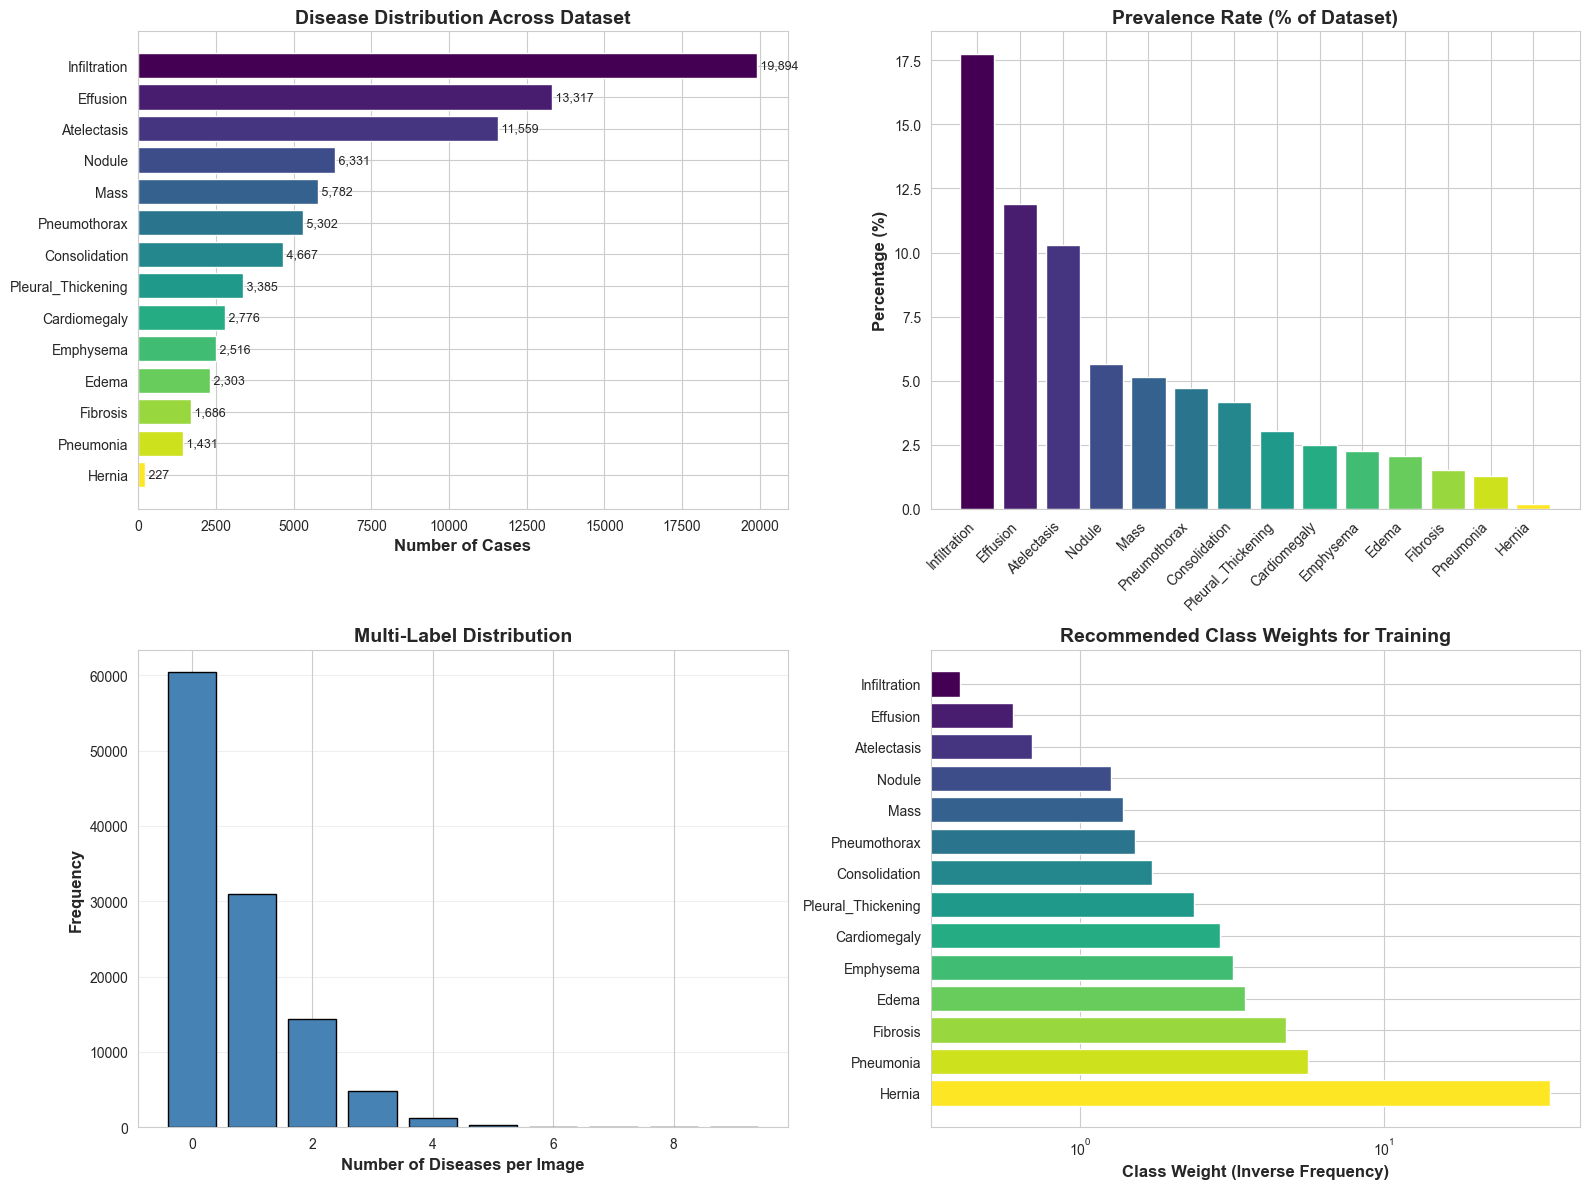

✓ Visualizations saved to: c:\Users\User\Sadeepa\X-Lite\results\01_eda_overview.png


In [16]:
# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 12)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Disease Distribution (Bar chart)
diseases = [d for d, _ in sorted_diseases]
counts_list = [c for _, c in sorted_diseases]
colors = plt.cm.viridis(np.linspace(0, 1, len(diseases)))

axes[0, 0].barh(diseases, counts_list, color=colors)
axes[0, 0].set_xlabel('Number of Cases', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Disease Distribution Across Dataset', fontsize=14, fontweight='bold')
axes[0, 0].invert_yaxis()

for i, v in enumerate(counts_list):
    axes[0, 0].text(v, i, f' {v:,}', va='center', fontsize=9)

# Plot 2: Disease Percentage
percentages = [(c/len(df)*100) for c in counts_list]
axes[0, 1].bar(range(len(diseases)), percentages, color=colors)
axes[0, 1].set_xticks(range(len(diseases)))
axes[0, 1].set_xticklabels(diseases, rotation=45, ha='right')
axes[0, 1].set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Prevalence Rate (% of Dataset)', fontsize=14, fontweight='bold')

# Plot 3: Diseases per Image
disease_dist = df['num_diseases'].value_counts().sort_index()
axes[1, 0].bar(disease_dist.index, disease_dist.values, color='steelblue', edgecolor='black')
axes[1, 0].set_xlabel('Number of Diseases per Image', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Multi-Label Distribution', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Class Weight Distribution (Log scale)
weights = [class_weights[d] for d in diseases]
axes[1, 1].barh(diseases, weights, color=colors)
axes[1, 1].set_xlabel('Class Weight (Inverse Frequency)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Recommended Class Weights for Training', fontsize=14, fontweight='bold')
axes[1, 1].set_xscale('log')
axes[1, 1].invert_yaxis()

plt.tight_layout()

# Create results directory if it doesn't exist
results_dir = project_root / 'results'
results_dir.mkdir(exist_ok=True)

plt.savefig(results_dir / '01_eda_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Visualizations saved to: {results_dir / '01_eda_overview.png'}")

## 10. Sample Visualization

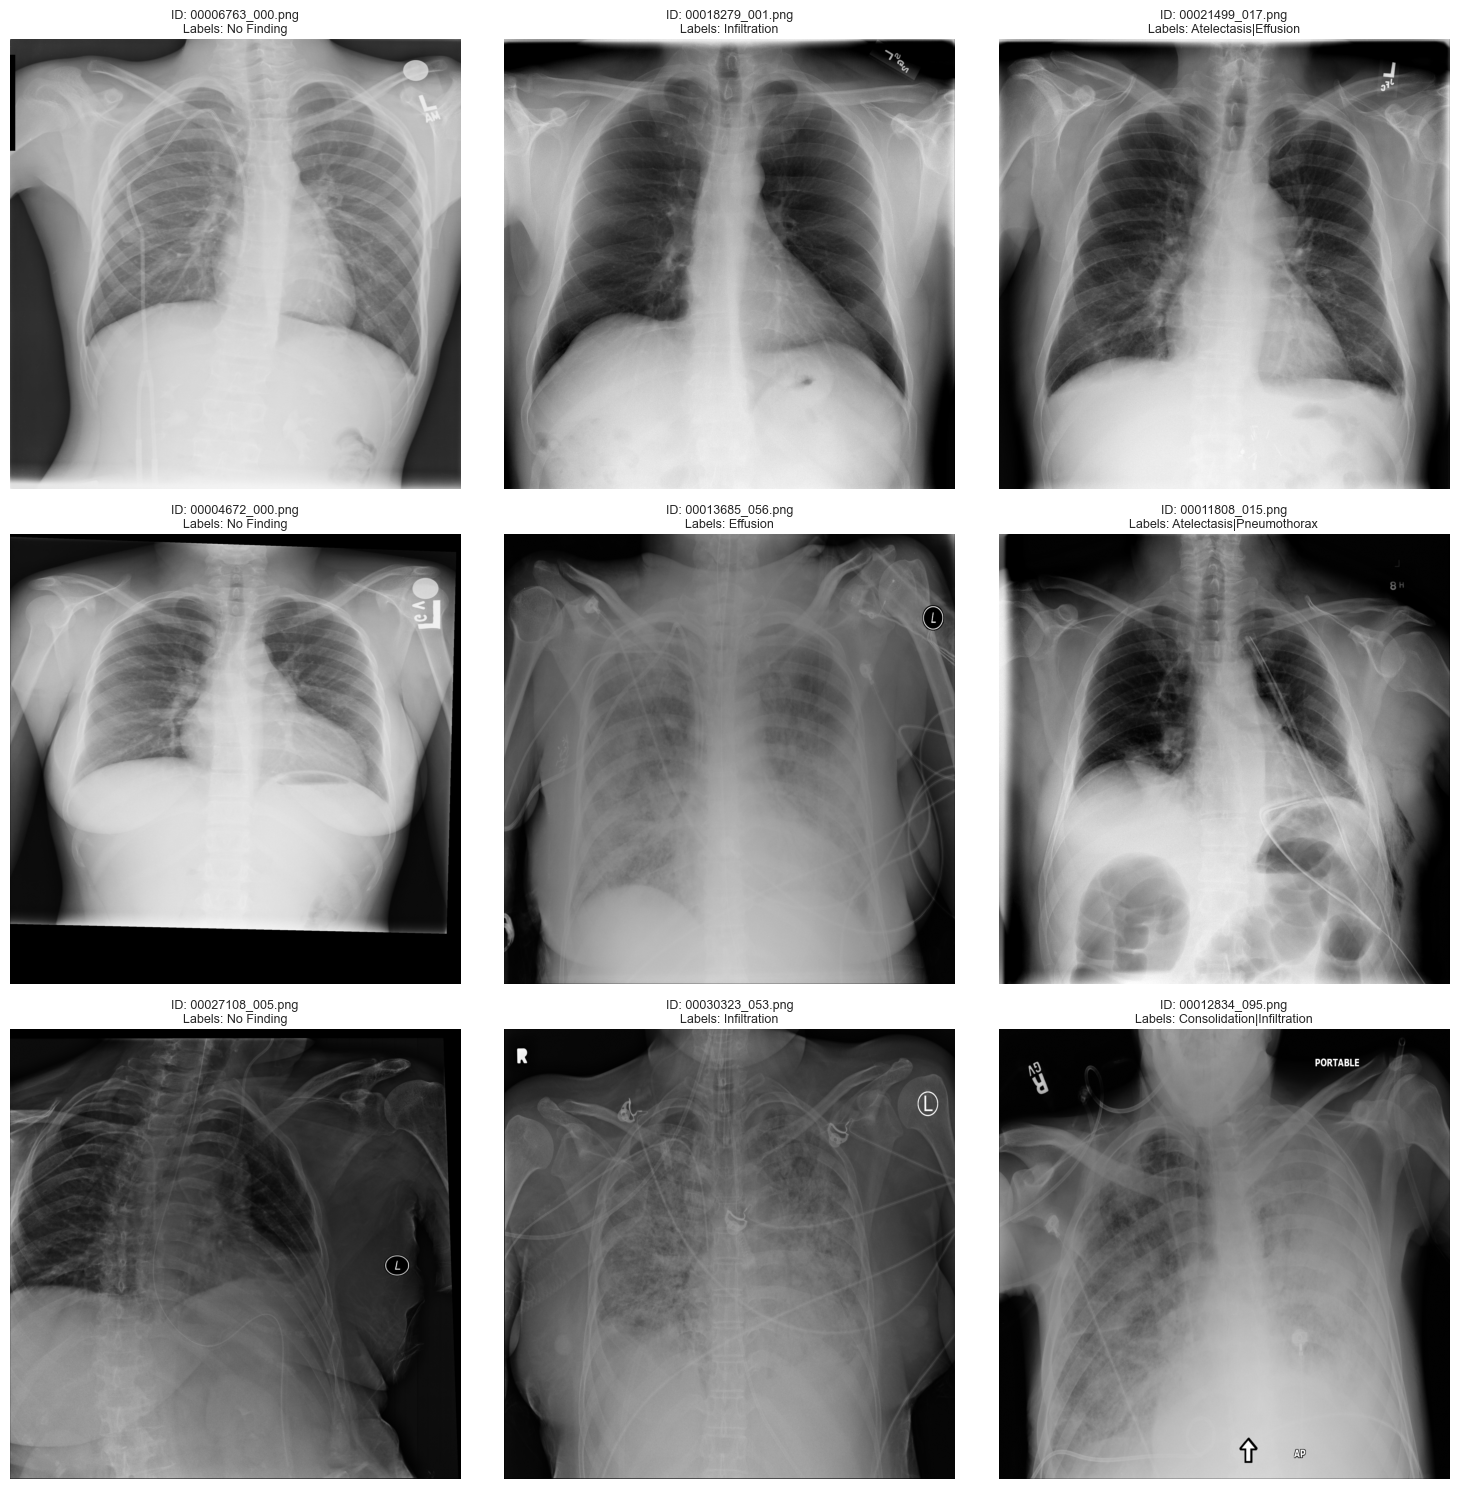

✓ Sample images saved to: results/02_sample_images.png


In [17]:
# Display sample images with their labels
image_dir = Config.RAW_DATA_DIR / 'images'

if image_dir.exists() and len(list(image_dir.glob("*.png"))) > 0:
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()
    
    # Get sample images with different disease counts
    samples = [
        df[df['num_diseases'] == 0].sample(1, random_state=42).iloc[0],  # Normal
        df[df['num_diseases'] == 1].sample(1, random_state=42).iloc[0],  # Single disease
        df[df['num_diseases'] == 2].sample(1, random_state=42).iloc[0],  # 2 diseases
        df[df['num_diseases'] == 0].sample(1, random_state=43).iloc[0],
        df[df['num_diseases'] == 1].sample(1, random_state=43).iloc[0],
        df[df['num_diseases'] == 2].sample(1, random_state=43).iloc[0],
        df[df['num_diseases'] == 0].sample(1, random_state=44).iloc[0],
        df[df['num_diseases'] == 1].sample(1, random_state=44).iloc[0],
        df[df['num_diseases'] == 2].sample(1, random_state=44).iloc[0],
    ]
    
    for idx, (ax, sample) in enumerate(zip(axes, samples)):
        image_id = sample.iloc[0]
        image_path = image_dir / image_id
        
        labels = sample.iloc[1]
        if pd.isna(labels):
            labels = 'No Finding'
        
        try:
            img = Image.open(image_path)
            ax.imshow(img, cmap='gray')
            ax.set_title(f"ID: {image_id}\nLabels: {labels}", fontsize=9, wrap=True)
            ax.axis('off')
        except Exception as e:
            ax.text(0.5, 0.5, f'Error loading:\n{image_id}', ha='center')
            ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('../../results/02_sample_images.png', dpi=200, bbox_inches='tight')
    plt.show()
    
    print("✓ Sample images saved to: results/02_sample_images.png")
else:
    print("⚠️  Images not available for visualization")

## 11. Stratification Strategy

In [22]:
from sklearn.model_selection import train_test_split

print("\n" + "="*70)
print("DATA STRATIFICATION STRATEGY")
print("="*70)

# Use disease count as stratification variable; cap the tail to avoid singleton classes
stratify_raw = df['num_diseases']
stratify_by = stratify_raw.clip(upper=3)  # 0,1,2,3 (3 = "3 or more")

print("Stratify bins (capped at 3):")
print(stratify_by.value_counts().sort_index())

# Split: 70% train, 15% val, 15% test
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=stratify_by,
    random_state=42
)

# Split temp into validation and test (15% each of total)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['num_diseases'].clip(upper=3),
    random_state=42
)

print("\nDataset Split:")
print(f"  Training set: {len(train_df):,} images ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Validation set: {len(val_df):,} images ({len(val_df)/len(df)*100:.1f}%)")
print(f"  Test set: {len(test_df):,} images ({len(test_df)/len(df)*100:.1f}%)")

print(f"\nStratification Validation (Multi-label distribution, capped at 3):")
print("-"*70)

for num_dis in sorted(stratify_by.unique()):
    train_count = len(train_df[train_df['num_diseases'].clip(upper=3) == num_dis])
    val_count = len(val_df[val_df['num_diseases'].clip(upper=3) == num_dis])
    test_count = len(test_df[test_df['num_diseases'].clip(upper=3) == num_dis])
    
    total = train_count + val_count + test_count
    train_pct = train_count/total*100 if total > 0 else 0
    val_pct = val_count/total*100 if total > 0 else 0
    test_pct = test_count/total*100 if total > 0 else 0
    
    bucket_label = f"{num_dis}" if num_dis < 3 else ">=3"
    print(f"{bucket_label} disease(s): Train {train_pct:.1f}% | Val {val_pct:.1f}% | Test {test_pct:.1f}%")

print("-"*70)
print("\n✓ Stratification successful - distributions preserved across splits (with capped bins)")



DATA STRATIFICATION STRATEGY
Stratify bins (capped at 3):
num_diseases
0    60361
1    30963
2    14306
3     6490
Name: count, dtype: int64

Dataset Split:
  Training set: 78,484 images (70.0%)
  Validation set: 16,818 images (15.0%)
  Test set: 16,818 images (15.0%)

Stratification Validation (Multi-label distribution, capped at 3):
----------------------------------------------------------------------
0 disease(s): Train 70.0% | Val 15.0% | Test 15.0%
1 disease(s): Train 70.0% | Val 15.0% | Test 15.0%
2 disease(s): Train 70.0% | Val 15.0% | Test 15.0%
>=3 disease(s): Train 70.0% | Val 15.0% | Test 15.0%
----------------------------------------------------------------------

✓ Stratification successful - distributions preserved across splits (with capped bins)


## 12. Class Imbalance Handling Recommendations

In [23]:
print("\n" + "="*70)
print("TRAINING STRATEGY: 14 SIGMOID OUTPUTS (Multi-Label Binary Classification)")
print("="*70)

print("""
✓ MODEL ARCHITECTURE
  • Output Layer: 14 sigmoid outputs (one per disease)
  • Each output: independent binary prediction [0, 1]
  • NO separate "No Finding" head (avoids class imbalance)

✓ LOSS FUNCTION
  • BCEWithLogitsLoss (multi-label binary cross-entropy)
  • Apply class weights (inverse frequency) from analysis
  • Formula: loss = -Σ(w_i * [y_i*log(σ(x_i)) + (1-y_i)*log(1-σ(x_i))])
  • Consider Focal Loss for harder negatives: helps with rare diseases

✓ TRAINING PROCEDURE
  • Dataset: {len(df):,} images × 14 binary labels
  • Stratify splits by disease count to preserve multi-label distribution
  • Use WeightedRandomSampler for balanced batches
  • Ensures each batch has balanced disease representation
  • Prevents overfitting to imbalanced classes

✓ INFERENCE PROCEDURE
  1. Forward pass: get 14 sigmoid outputs in [0, 1]
  2. Apply threshold (typically 0.5 per disease, or tune per-class)
  3. Get binary prediction for each of 14 diseases
  4. If all 14 predictions are 0 → "No Finding"
  5. Otherwise → reported diseases are those with prediction = 1

✓ VALIDATION METRICS
  • Primary: Per-disease AUC-ROC (target >0.80 each)
  • Secondary: F1-score (macro for overall, weighted for sample-weighted)
  • Supplementary: Precision, Recall, Sensitivity, Specificity per disease
  • Ignore: Accuracy (misleading with multi-label binary)
  • Track: Hamming Loss (fraction of incorrect labels per sample)

✓ CLASS IMBALANCE HANDLING
  • Class weights: {sorted(class_weights.items(), key=lambda x: x[1], reverse=True)[:3]}
  • Weighted sampling: ensures rare diseases seen regularly
  • Effective samples: calculated accounting for label frequency
  • Avoids "No Finding" domination by keeping 14 binary heads

✓ WHY NOT 15th HEAD for "No Finding"?
  ✗ "No Finding" is highly imbalanced ({images_with_no_disease/len(df)*100:.1f}% of data)
  ✗ Adding it as 15th class makes imbalance worse
  ✗ Redundant: already encoded in 14 binary outputs
  ✗ Makes training optimization harder (competing gradients)
  ✓ Standard approach: CheXNet, CheXViT, most SOTA models
""")

print("="*70)



TRAINING STRATEGY: 14 SIGMOID OUTPUTS (Multi-Label Binary Classification)

✓ MODEL ARCHITECTURE
  • Output Layer: 14 sigmoid outputs (one per disease)
  • Each output: independent binary prediction [0, 1]
  • NO separate "No Finding" head (avoids class imbalance)

✓ LOSS FUNCTION
  • BCEWithLogitsLoss (multi-label binary cross-entropy)
  • Apply class weights (inverse frequency) from analysis
  • Formula: loss = -Σ(w_i * [y_i*log(σ(x_i)) + (1-y_i)*log(1-σ(x_i))])
  • Consider Focal Loss for harder negatives: helps with rare diseases

✓ TRAINING PROCEDURE
  • Dataset: {len(df):,} images × 14 binary labels
  • Stratify splits by disease count to preserve multi-label distribution
  • Use WeightedRandomSampler for balanced batches
  • Ensures each batch has balanced disease representation
  • Prevents overfitting to imbalanced classes

✓ INFERENCE PROCEDURE
  1. Forward pass: get 14 sigmoid outputs in [0, 1]
  2. Apply threshold (typically 0.5 per disease, or tune per-class)
  3. Get bina

## 13. Export Processed Splits

In [24]:
# Create splits directory
splits_dir = project_root / 'data' / 'splits'
splits_dir.mkdir(exist_ok=True)

# Save splits
train_path = splits_dir / 'train.csv'
val_path = splits_dir / 'val.csv'
test_path = splits_dir / 'test.csv'

train_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)
test_df.to_csv(test_path, index=False)

print("\n" + "="*70)
print("DATA SPLITS EXPORTED")
print("="*70)

print(f"\n✓ Training split: {train_path}")
print(f"  Samples: {len(train_df):,}")

print(f"\n✓ Validation split: {val_path}")
print(f"  Samples: {len(val_df):,}")

print(f"\n✓ Test split: {test_path}")
print(f"  Samples: {len(test_df):,}")

print(f"\n✓ All splits saved to: {splits_dir}")


DATA SPLITS EXPORTED

✓ Training split: c:\Users\User\Sadeepa\X-Lite\data\splits\train.csv
  Samples: 78,484

✓ Validation split: c:\Users\User\Sadeepa\X-Lite\data\splits\val.csv
  Samples: 16,818

✓ Test split: c:\Users\User\Sadeepa\X-Lite\data\splits\test.csv
  Samples: 16,818

✓ All splits saved to: c:\Users\User\Sadeepa\X-Lite\data\splits


## 14. Summary & Key Findings

In [26]:
summary = f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║          EXPLORATORY DATA ANALYSIS SUMMARY (14 Sigmoid Outputs)              ║
╚══════════════════════════════════════════════════════════════════════════════╝

📊 DATASET OVERVIEW
   • Total Images: {len(df):,}
   • Output Heads: 14 (one sigmoid per disease)
   • Multi-label: {len(df[df['num_diseases'] > 1]):,} images ({len(df[df['num_diseases'] > 1])/len(df)*100:.1f}%)
   • No Finding: {images_with_no_disease:,} images ({images_with_no_disease/len(df)*100:.1f}%)

⚠️  CLASS IMBALANCE (Among 14 Diseases)
   • Imbalance ratio: {imbalance_ratio:.1f}:1
   • Gini coefficient: {gini:.4f} (manageable with 14 outputs)
   • Most prevalent: {sorted_diseases[0][0]} ({sorted_diseases[0][1]:,} cases)
   • Least prevalent: {sorted_diseases[-1][0]} ({sorted_diseases[-1][1]:,} cases)

📈 MULTI-LABEL DISTRIBUTION
   • Average diseases per image: {df['num_diseases'].mean():.2f}
   • Single disease: {len(df[df['num_diseases']==1])/len(df)*100:.1f}%
   • Multiple diseases: {len(df[df['num_diseases']>1])/len(df)*100:.1f}%
   • No disease: {len(df[df['num_diseases']==0])/len(df)*100:.1f}%

🎯 TRAINING APPROACH
   ✓ Output Layer: 14 sigmoid outputs (BCEWithLogitsLoss)
   ✓ No 15th "No Finding" head (avoids imbalance amplification)
   ✓ Inference: All outputs < threshold → "No Finding"
   ✓ Class weights calculated for imbalanced disease frequencies
   ✓ Stratified train/val/test splits (preserves multi-label dist)

🔧 MITIGATION STRATEGIES
   ✓ Inverse frequency class weights: {[f'{sorted_diseases[i][0][:15]}: {class_weights[sorted_diseases[i][0]]:.3f}' for i in range(min(3, len(sorted_diseases)))]}...
   ✓ Weighted sampling during training
   ✓ Per-class evaluation (AUC-ROC, F1, precision, recall)
   ✓ Focal loss option for harder negatives

💾 DATA READY FOR MODEL TRAINING
   ✓ Metadata: {len(df):,} records validated
   ✓ Splits: train/val/test stratified
   ✓ Labels: 14 binary sigmoid outputs
   ✓ Class weights: calculated and ready

⚡ NEXT STEPS
   1. Configure data loader with WeightedRandomSampler
   2. Implement BCEWithLogitsLoss with class weights
   3. Setup per-disease evaluation metrics
   4. Build model with 14 sigmoid outputs
   5. Train with weighted sampling + class weights
   6. Validate per-class AUC-ROC (target >0.80)
   7. At inference: threshold outputs, derive "No Finding"

═══════════════════════════════════════════════════════════════════════════════
Model: 14 Sigmoid Outputs (CheXNet-style, SOTA approach)
Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
═══════════════════════════════════════════════════════════════════════════════
"""

print(summary)

# Save summary to file
with open(project_root / 'docs' / 'EDA_REPORT.md', 'w', encoding='utf-8') as f:
    f.write(summary.replace('║', '|').replace('╔', '').replace('╚', '').replace('╠', '').replace('╣', ''))

print(f"\n✓ EDA Report saved to: docs/EDA_REPORT.md")



╔══════════════════════════════════════════════════════════════════════════════╗
║          EXPLORATORY DATA ANALYSIS SUMMARY (14 Sigmoid Outputs)              ║
╚══════════════════════════════════════════════════════════════════════════════╝

📊 DATASET OVERVIEW
   • Total Images: 112,120
   • Output Heads: 14 (one sigmoid per disease)
   • Multi-label: 20,796 images (18.5%)
   • No Finding: 60,361 images (53.8%)

⚠️  CLASS IMBALANCE (Among 14 Diseases)
   • Imbalance ratio: 87.6:1
   • Gini coefficient: 0.4652 (manageable with 14 outputs)
   • Most prevalent: Infiltration (19,894 cases)
   • Least prevalent: Hernia (227 cases)

📈 MULTI-LABEL DISTRIBUTION
   • Average diseases per image: 0.72
   • Single disease: 27.6%
   • Multiple diseases: 18.5%
   • No disease: 53.8%

🎯 TRAINING APPROACH
   ✓ Output Layer: 14 sigmoid outputs (BCEWithLogitsLoss)
   ✓ No 15th "No Finding" head (avoids imbalance amplification)
   ✓ Inference: All outputs < threshold → "No Finding"
   ✓ Class weights 